### Note: This notebook is meant to run on Google Colab

In [ ]:
import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image

import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
import numpy as np
from google.colab import files
from torch.utils.data import Subset

import time
import json

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: True 


In [ ]:
pip install segmentation-models-pytorch

In [ ]:
import segmentation_models_pytorch as smp

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Download the data from web

In [ ]:
%pwd
%mkdir adl_data

In [ ]:
%cd adl_data
%pwd

/content/adl_data


'/content/adl_data'

In [ ]:
# Download data
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

In [ ]:
# Unzip data
!tar zxvf images.tar.gz
!tar zxvf annotations.tar.gz

In [ ]:
%ls

annotations/  annotations.tar.gz  images/  images.tar.gz


In [ ]:
# Delete irragular files
%cd /content/adl_data/annotations/trimaps
!find . -type f -name '._*.png' -print
!find . -type f -name '._*.png' -exec rm {} +

%cd /content/adl_data/images
!find . -type f -name '*.mat' -print
!find . -type f -name '*.mat' -exec rm {} +


## Download the backbone model

In [ ]:
# Download simclr_backbone from my googld drive
%cd /content/
# Cifar pretrain ResNet50 backbone
! gdown --id 1y-_Uq9T4n1aOIdAomFn5pBjUXFu0zDfa # 1n4O_5rCcKv_UxSrSELV670fxsy3aLLgP

# Cat & dog pretrain ResNet50 backbone
! gdown --id 1m0qQDXLLtt-eqXTB82cDpHJSRVhxRAMp #1wGZIR7hEaIT1DtxockGfEknZx0exXmS_


/content
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1y-_Uq9T4n1aOIdAomFn5pBjUXFu0zDfa
From (redirected): https://drive.google.com/uc?id=1y-_Uq9T4n1aOIdAomFn5pBjUXFu0zDfa&confirm=t&uuid=f54c4356-8889-4342-8e79-c4e92ad65a24
To: /content/cifar_simclr_backbone.ckpt
100% 94.4M/94.4M [00:00<00:00, 126MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1m0qQDXLLtt-eqXTB82cDpHJSRVhxRAMp
From (redirected): https://drive.google.com/uc?id=1m0qQDXLLtt-eqXTB82cDpHJSRVhxRAMp&confirm=t&uuid=8d96e704-19e8-43f4-a310-6c778febbd62
To: /content/

## Dataloader

In [ ]:
import numpy as np
import random

seed_value = 42
torch.manual_seed(seed_value)
np.random.seed(seed_value)
random.seed(seed_value)

# CUDA randomness
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)  # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


In [ ]:
# IMPORTANT TRAINING SETTING

PRETRAIN_DATASET = 'cifar'
LOSS_FUNC = 'BCE'
DEV_SIZE = 20
SAVE_PATH = '/content/drive/MyDrive/Applied_Deep_Learning_UCL'


In [ ]:

def create_split_indices(dataset_size, test_split=0.2, random_seed=42):
    # Setting the random seed for reproducibility
    torch.manual_seed(random_seed)

    # Generating shuffled indices
    indices = torch.randperm(dataset_size).tolist()

    # Calculating the split index
    split = int(len(indices) * (1 - test_split))

    # Splitting the indices
    train_indices, test_indices = indices[:split], indices[split:]

    return train_indices, test_indices

def get_dataset_subsets(dataset, train_indices, test_indices):
    train_subset = Subset(dataset, train_indices)
    test_subset = Subset(dataset, test_indices)
    return train_subset, test_subset


def save_indices(filename, indices, download = False):
  # Open a file in write mode ('w') and use a context manager
  with open(filename, 'w') as f:
      for index in indices:
          # Write each index to the file, followed by a newline character
          f.write(f"{index}\n")

  print(f'{filename} is saved.')

  if download:
    files.download(filename)

def load_indices(filename):
    # Open the file in read mode ('r') and use a context manager
  with open(filename, 'r') as f:
      # Read the lines, convert each line back to an integer, and remove newline characters
      loaded_indices = [int(line.strip()) for line in f]
  print(f'{filename} is loaded.')
  return loaded_indices



In [ ]:
class OxfordPetsDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None, mask_transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.mask_transform = mask_transform if mask_transform is not None else transform

        self.images = sorted(os.listdir(images_dir))
        self.masks = sorted(os.listdir(masks_dir))

    def __len__(self):
        return len(self.images)

    def preprocess_mask(self, mask):
        mask = mask.astype(np.float32)
        mask[mask == 2.0] = 0.0 # Background
        # mask[(mask == 1.0)] = 0.5 # Item
        mask[(mask == 3.0) | (mask == 1.0)] = 1.0 # Edge
        return mask

    # It defines how an item from the dataset is fetched given its index
    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.images[idx])
        mask_path = os.path.join(self.masks_dir, self.masks[idx])
        image = Image.open(img_path).convert("RGB")
        trimap = np.array(Image.open(mask_path))
        mask = self.preprocess_mask(trimap)
        mask = Image.fromarray(mask)

        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask


def data_split(dataset, ignore_size = 0):

  final_dev_size = 1 - 0.2 - ignore_size

  ignore_portion = 1 - (final_dev_size / 0.8)

  # Create split indices
  dev_indices, test_indices = create_split_indices(len(dataset), test_split=0.2, random_seed=42)

  dev_indices, ignore_indices = create_split_indices(len(dev_indices), test_split=ignore_portion, random_seed=42)

  # Create dataset subsets
  dev_set, test_set = get_dataset_subsets(dataset, dev_indices, test_indices)

  # Create split indices
  train_indices, val_indices = create_split_indices(len(dev_indices), test_split=0.1, random_seed=42)
  # Create dataset subsets
  train_set, val_set = get_dataset_subsets(dev_set, train_indices, val_indices)

  save_indices('/content/train_indices.txt', train_indices, True)
  save_indices('/content/val_indices.txt', val_indices, True)
  save_indices('/content/test_indices.txt', test_indices, True)

  train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
  test_loader = DataLoader(test_set, batch_size=64, shuffle=True)
  val_loader = DataLoader(val_set, batch_size=64, shuffle=True)

  print(f'Train set size: {len(train_set)}, Test set size: {len(test_set)}, Val set size: {len(val_set)}, Total data size: {len(dataset)}')
  print(f'Train set %: {len(train_set)/len(dataset) * 100}, Test set %: {len(test_set)/len(dataset) * 100}, Val set %: {len(val_set)/len(dataset) * 100}')

  return train_loader, test_loader, val_loader


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])
mask_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataset = OxfordPetsDataset(images_dir='/content/adl_data/images', masks_dir='/content/adl_data/annotations/trimaps', transform=transform, mask_transform=mask_transform)

In [ ]:
if DEV_SIZE == 80:
  train_loader, test_loader, val_loader = data_split(dataset, ignore_size = 0)
elif DEV_SIZE == 50:
  train_loader, test_loader, val_loader = data_split(dataset, ignore_size = 0.3)
elif DEV_SIZE == 20:
  train_loader, test_loader, val_loader = data_split(dataset, ignore_size = 0.6)

/content/train_indices.txt is saved.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/content/val_indices.txt is saved.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/content/test_indices.txt is saved.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Train set size: 5320, Test set size: 1478, Val set size: 592, Total data size: 7390
Train set %: 71.98917456021651, Test set %: 20.0, Val set %: 8.01082543978349


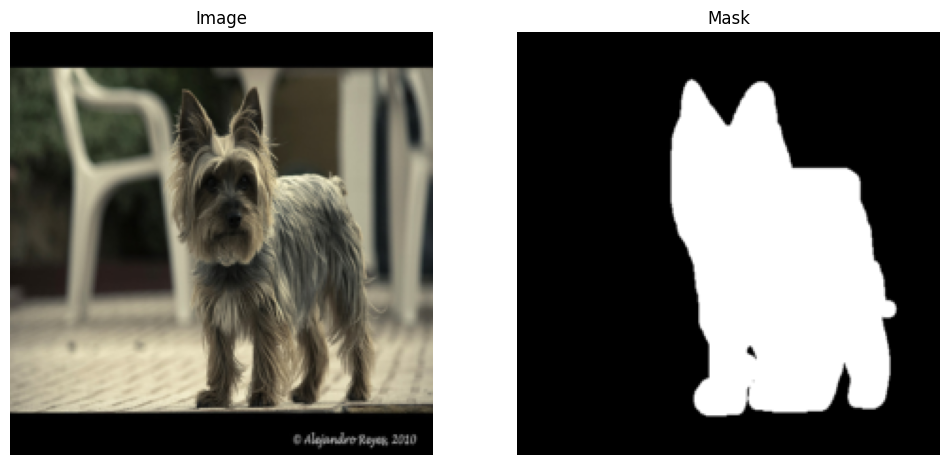

In [ ]:
# Inspect dataset
image, mask = dataset[7389]

# Rearrange the dimensions
# from (channels, height, width) to (height, width, channels)
image_np = image.numpy().transpose(1, 2, 0)

# Normalize the image array to [0, 1] for visualization
# This reverses the normalization applied during the transform
image_np = (image_np * [0.5, 0.5, 0.5]) + [0.5, 0.5, 0.5]
image_np = np.clip(image_np, 0, 1)  # clip to the range [0, 1] for valid image values

# Convert the mask tensor to a numpy array for visualization
# Since the mask is a single-channel image, we use squeeze to remove the channel dimension for plotting
mask_np = mask.numpy().squeeze()

# Visualize the image
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image_np)
plt.title('Image')
plt.axis('off')

# Visualize the mask
plt.subplot(1, 2, 2)
plt.imshow(mask_np, cmap='gray')
plt.title('Mask')
plt.axis('off')

plt.show()


In [ ]:

# SEGMENTATION HEAD V1: FULLY-CONVOLUTED HEAD

from torchvision.models import resnet50

class SegmentationHead(nn.Module):
    def __init__(self, in_channels=2048, out_channels=1, feature_size=(224, 224)):
        super(SegmentationHead, self).__init__()
        # Assuming we want to output a single-channel binary segmentation map
        self.upsample = nn.Upsample(size=feature_size, mode='bilinear', align_corners=True)
        self.conv1 = nn.Conv2d(in_channels, 512, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(512, out_channels, kernel_size=1)

    def forward(self, x):
        x = self.upsample(x)
        x = self.relu(self.conv1(x))
        x = self.conv2(x)
        # No activation here, assuming the use of BCEWithLogitsLoss which combines sigmoid
        return x


class ResNetSegmentation(nn.Module):
    def __init__(self, backbone, segmentation_head):
        super(ResNetSegmentation, self).__init__()
        self.backbone = backbone
        self.segmentation_head = segmentation_head

    def forward(self, x):
        for param in self.backbone.parameters():
          param.requires_grad = False
        # Pass input through ResNet backbone
        features = self.backbone(x)
        # Pass backbone features through segmentation head
        segmentation_output = self.segmentation_head(features)
        return segmentation_output

device = torch.device("cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))

# Initialize ResNet backbone
backbone = resnet50(pretrained=False)

# Load the pre-trained weights
backbone.load_state_dict(torch.load("/content/pet_simclr_backbone.ckpt", map_location=torch.device(device)), strict=False)

# Remove avgpool and fc, try the below code to see the original architecture
# print(list(backbone.children()))
backbone = nn.Sequential(*(list(backbone.children())[:-2]))

for param in backbone.parameters():
    param.requires_grad = False

# Initialize segmentation head
segmentation_head = SegmentationHead(in_channels=2048, out_channels=1, feature_size=(224, 224))

# Combine into a full model
model = ResNetSegmentation(backbone=backbone, segmentation_head=segmentation_head)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
# SEGMENTATION HEAD V2: UNET

import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="resnet50",  # choose encoder, use `resnet50` for ResNet50
    encoder_weights=None,     # use `None` to not load the pre-trained weights
    in_channels=3,            # model input channels (1 for grayscale images, 3 for RGB, etc.)
    classes=1,                # model output channels (number of classes in your dataset)
)


if PRETRAIN_DATASET == 'pet':
  # Load the weights into the model
  model.load_state_dict(torch.load("/content/pet_simclr_backbone.ckpt", map_location=torch.device(device)), strict=False)
elif PRETRAIN_DATASET == 'cifar':
  model.load_state_dict(torch.load("/content/cifar_simclr_backbone.ckpt", map_location=torch.device(device)), strict=False)
else: # baseline
  pass

# # Freeze encoder (pre-trained backbone) weights
# for param in model.encoder.parameters():
#   param.requires_grad = False


In [ ]:
def print_requires_grad_status(model):
    for name, param in model.named_parameters():
        print(f"{name} requires_grad: {param.requires_grad}")

print_requires_grad_status(model)


In [ ]:
def train_segmentation_model(model, train_loader, val_loader, num_epochs=10, loss_type='dice', learning_rate=1e-4, device='cpu', model_name = 'model'):

    global SAVE_PATH

    print(f'Training {model_name}')

    start_time = time.time()
    # Set the model to training mode and move it to the specified device
    model.train()
    model.to(device)

    # Define the optimizer - only parameters with requires_grad=True will be updated
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)

    # Define the loss function
    if loss_type == 'dice':
      criterion = smp.losses.DiceLoss(mode = 'binary')
    elif loss_type == 'docal':
      criterion = smp.losses.FocalLoss(mode = 'binary')
    else:
      # Binary Cross Entropy Loss With Sigmoid Function
      criterion = nn.BCEWithLogitsLoss()

    # Monitor loss in validation set
    dice_loss_fn = smp.losses.DiceLoss(mode='binary')
    focal_loss_fn = smp.losses.FocalLoss(mode='binary')
    bce_loss_fn = nn.BCEWithLogitsLoss()

    # List to store loss values per batch
    batch_loss_list = []
    iou_scores_list, f1_scores_micro_list, f1_scores_macro_list, dice_loss_list, focal_loss_list, bce_loss_list = [], [], [], [], [], []

    best_iou = 0

    for epoch in range(num_epochs):
        running_loss_batch = 0.0
        running_loss = 0.0

        batch_loss_values = []

        for i, (images, masks) in enumerate(train_loader):
            images = images.to(device)

            # Ensure masks are LongTensor and on the correct device
            masks = masks.float().to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)

            # Calculate loss
            loss = criterion(outputs, masks)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Compute loss per every batch and cummulative loss
            running_loss_batch += loss.item()
            running_loss += loss.item()

            batch_loss_values.append(loss.item())

            if (i+1) % 10 == 0 :    # Print every 10 mini-batches
                print(f'[%d, %5d] {loss_type} loss: %.3f' %
                    (epoch + 1, i + 1, running_loss_batch / 10))
                running_loss_batch = 0

        train_loss = running_loss / (len(train_loader) * train_loader.batch_size) # Total loss / total number of training data
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss}')
        batch_loss_list.append(batch_loss_values)

        if (epoch + 1)%2 ==0:
          model.eval()
          iou_scores, f1_scores_micro, f1_scores_macro, dice_loss, focal_loss, bce_loss = [], [], [], [], [], []

          with torch.no_grad():
              # Compute metrics on every batch
              for images, masks in val_loader:
                  images, masks = images.to(device), masks.float().to(device)
                  outputs = model(images)

                  # Compute SMP metrics
                  tp, fp, fn, tn = smp.metrics.get_stats(masks.long(), outputs.long(), mode='binary', threshold=0.5)

                  # For 'binary' case 'micro' = 'macro' = 'weighted'
                  iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
                  f1_score_micro = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
                  f1_score_macro = smp.metrics.f1_score(tp, fp, fn, tn, reduction="macro")

                  iou_scores.append(iou_score.item())
                  f1_scores_micro.append(f1_score_micro.item())
                  f1_scores_macro.append(f1_score_macro.item())
                  dice_loss.append(dice_loss_fn(outputs, masks).item())
                  focal_loss.append(focal_loss_fn(outputs, masks).item())
                  bce_loss.append(bce_loss_fn(outputs, masks).item())

          mean_iou = np.mean(iou_scores)
          mean_fscore_micro = np.mean(f1_scores_micro)
          mean_fscore_macro = np.mean(f1_scores_macro)
          mean_dice = np.mean(dice_loss)
          mean_focal = np.mean(focal_loss)
          mean_bce = np.mean(bce_loss)

          print(f'Validation (Epoch {epoch + 1}) - IoU: {mean_iou:.4f}, F1-score-micro: {mean_fscore_micro:.4f}, F1-score-macro: {mean_fscore_macro:.4f}, Dice-loss: {mean_dice:.4f}, Focal-loss: {mean_focal:.4f}, BCE-loss: {mean_bce:.4f}')

          iou_scores_list.append(mean_iou)
          f1_scores_micro_list.append(mean_fscore_micro)
          f1_scores_macro_list.append(mean_fscore_macro)
          dice_loss_list.append(mean_dice)
          focal_loss_list.append(mean_focal)
          bce_loss_list.append(mean_bce)

          if mean_iou > best_iou:
            # Example of saving a checkpoint after 10 epoch
            torch.save({
                  'epoch': epoch,
                  'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'loss': batch_loss_values[-1],  # Last batch loss of the epoch
              }, f'{SAVE_PATH}/{model_name}.pth')
            best_iou = mean_iou
            print(f'Epoch {epoch+1} checkpoint is saved.')

    # Save the final model
    torch.save(model.state_dict(), f'{SAVE_PATH}/{model_name}_model.pth')

    # Automatically prompt the browser to download the file to your local machine
    # files.download(f'/content/{model_name}.pth')
    # files.download(f'/content/{model_name}_model.pth')
    print(f'Total training time: {time.time()-start_time:4f}s')

    metrics = {'batch_loss': batch_loss_list,
               'iou': iou_scores_list,
               'f1_micro': f1_scores_micro_list,
               'f1_macro': f1_scores_macro_list,
               'dice': dice_loss_list,
               'focal': focal_loss_list,
               'BCE': bce_loss_list}

    return model, metrics

# Call the training function

model_name = f'{PRETRAIN_DATASET}_{LOSS_FUNC}_{DEV_SIZE}'
model, metrics = train_segmentation_model(model, train_loader, val_loader, num_epochs=60, loss_type=LOSS_FUNC, learning_rate=1e-4, device=device, model_name = model_name)

print('Check metrics file')
for key, value in metrics.items():
  print(key, len(value))

filename = f'{SAVE_PATH}/{PRETRAIN_DATASET}_{LOSS_FUNC}_{DEV_SIZE}.json'

# Writing the dictionary to a file in JSON format
with open(filename, 'w') as f:
    json.dump(metrics, f)

files.download(filename)


Training cifar_BCE_80
[1,    10] BCE loss: 0.691
[1,    20] BCE loss: 0.591
[1,    30] BCE loss: 0.526
[1,    40] BCE loss: 0.500
[1,    50] BCE loss: 0.482
[1,    60] BCE loss: 0.462
[1,    70] BCE loss: 0.449
[1,    80] BCE loss: 0.442
Epoch [1/60], Loss: 0.008016254686351334
[2,    10] BCE loss: 0.425
[2,    20] BCE loss: 0.421
[2,    30] BCE loss: 0.430
[2,    40] BCE loss: 0.405
[2,    50] BCE loss: 0.421
[2,    60] BCE loss: 0.412
[2,    70] BCE loss: 0.403
[2,    80] BCE loss: 0.396
Epoch [2/60], Loss: 0.006455640596825452
Validation (Epoch 2) - IoU: 0.5909, F1-score-micro: 0.7427, F1-score-macro: 0.7427, Dice-loss: 0.2810, Focal-loss: 0.1733, BCE-loss: 0.4102
Epoch 2 checkpoint is saved.
[3,    10] BCE loss: 0.650
[3,    20] BCE loss: 0.509
[3,    30] BCE loss: 0.478
[3,    40] BCE loss: 0.457
[3,    50] BCE loss: 0.432
[3,    60] BCE loss: 0.423
[3,    70] BCE loss: 0.421
[3,    80] BCE loss: 0.409
Epoch [3/60], Loss: 0.007325394400617196
[4,    10] BCE loss: 0.407
[4,    20] 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Load models or checkpoints

# model = ResNetSegmentation(backbone=backbone, segmentation_head=segmentation_head)
checkpoint = torch.load('/content/checkpoint_epoch_30.pth')
model.load_state_dict(checkpoint['model_state_dict'])
# model.load_state_dict(torch.load("/content/final_model_new.pth", map_location=torch.device(device)), strict=False)
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()


In [ ]:
# Clear RAM space for colab
import gc

del train_loader
del test_loader
del val_loader
del model

# Collect garbage
gc.collect()

# If using PyTorch and want to free up GPU memory:
torch.cuda.empty_cache()